In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor


from xgboost import XGBRegressor

import optuna

In [30]:
df_matches = pd.read_csv("matches.csv")

## Baseline Models

In [31]:
class StaticEstimator(BaseEstimator):
    def __init__(self, result) -> None:
        super().__init__()
        self.result = result

    def fit(self, X, y):
        pass

    def predict(self, X):
        results = np.zeros((len(X), 2))
        results[:] = self.result
        return results

class RandomEstimator(BaseEstimator):
    
    def fit(self, X, y):
        df_result_counts = df_matches[["team1Goals", "team2Goals"]].value_counts().reset_index()
        df_result_counts["p"] = df_result_counts["count"] / len(df_matches)
        self.df_result_counts = df_result_counts

    def predict(self, X):
        df_result_counts = self.df_result_counts
        result_indices = np.random.choice(df_result_counts.index, len(X), p=df_result_counts["p"].values)
        return df_result_counts.loc[result_indices, ["team1Goals", "team2Goals"]].values

0:0: 187.69 +- 17.45
1:1: 223.38 +- 17.01
1:0: 354.46 +- 25.95
0:1: 245.77 +- 20.83
random: 276.77 +- 24.57


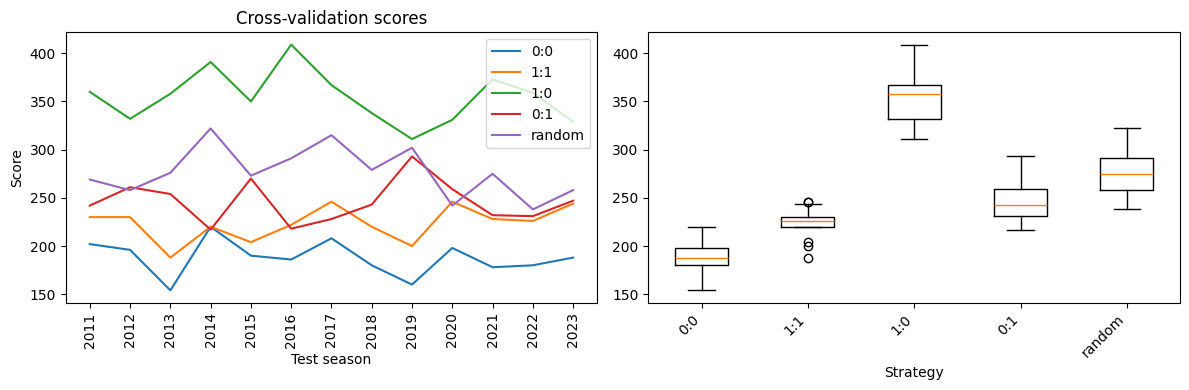

In [32]:
from utils import cross_val_splits, kicktipp_scoring


def evaluate_simple_models(scoring):
    splits = cross_val_splits(df_matches)
    labels = df_matches[["team1Goals", "team2Goals"]].values
    static_results = [[0, 0], [1, 1], [1, 0], [0, 1]]
    static_result_scores = []
    for result in static_results:
        scores = cross_val_score(StaticEstimator(result), df_matches, labels, cv=splits, scoring=scoring)
        static_result_scores.append(scores)
    static_result_scores = np.array(static_result_scores)

    random_scores = cross_val_score(RandomEstimator(), df_matches, labels, cv=splits, scoring=scoring)

    all_scores = np.vstack((static_result_scores, random_scores))
    labels = [f"{res[0]}:{res[1]}" for res in static_results] + ["random"]
    for score, label in zip(all_scores, labels):
        print(f"{label}: {score.mean():.2f} +- {score.std():.2f}")

    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    split_test_seasons = [df_matches.iloc[split[1][0]]["leagueSeason"] for  split in splits]
    axs[0].plot(all_scores.T, label=labels)
    axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
    axs[0].set_xlabel("Test season")
    axs[0].set_ylabel("Score")
    axs[0].legend()
    axs[0].set_title("Cross-validation scores")

    axs[1].boxplot(all_scores.T)
    axs[1].set_xlabel("Strategy")
    axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=45, ha="right")
    fig.tight_layout()

evaluate_simple_models(scoring=kicktipp_scoring)

# Matches with team context

In [33]:
df_full = pd.read_csv("matches_with_context.csv", index_col="id")
df_full.tail()

,date,matchDay,matchDayID,leagueID,leagueName,leagueSeason,team1ID,team1Name,team1Short,team2ID,...,guest_opponentGoals,guest_points,guest_won,guest_draw_mean_previous,guest_goalDiff_mean_previous,guest_goals_mean_previous,guest_lost_mean_previous,guest_opponentGoals_mean_previous,guest_points_mean_previous,guest_won_mean_previous
id,,,,,,,,,,,,,,,,,,,,,
66932,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,131,VfL Wolfsburg,Wolfsburg,81,...,55.0,46.0,12.0,8.083333,-5.166667,45.416667,14.166667,50.583333,43.333333,11.750000
66933,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,175,TSG 1899 Hoffenheim,Hoffenheim,40,...,38.0,71.0,21.0,4.833333,61.833333,89.583333,3.916667,27.750000,80.583333,25.250000
66934,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,134,Werder Bremen,Bremen,129,...,72.0,35.0,10.0,6.000000,-14.000000,38.000000,16.000000,52.000000,42.000000,12.000000
66935,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,16,VfB Stuttgart,Stuttgart,87,...,55.0,43.0,11.0,7.833333,7.916667,54.333333,11.416667,46.416667,52.083333,14.750000
66936,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,199,1. FC Heidenheim 1846,Heidenheim,65,...,54.0,42.0,10.0,9.111111,-14.222222,42.333333,15.000000,56.555556,38.777778,9.888889


In [34]:
X_all = df_full.drop(columns=["team1Goals", "team2Goals", "matchDay", "result", "leagueName", "leagueID", "date", "team1Short", "team1Name", "team2Short", "team2Name", "host_team", "guest_team"])
y_all = df_full[["team1Goals", "team2Goals"]].values
print(X_all.columns)

Index(['matchDayID', 'leagueSeason', 'team1ID', 'team2ID', 'last_season',
       'host_year', 'host_draw', 'host_goalDiff', 'host_goals', 'host_lost',
       'host_matches', 'host_opponentGoals', 'host_points', 'host_won',
       'host_draw_mean_previous', 'host_goalDiff_mean_previous',
       'host_goals_mean_previous', 'host_lost_mean_previous',
       'host_opponentGoals_mean_previous', 'host_points_mean_previous',
       'host_won_mean_previous', 'guest_year', 'guest_draw', 'guest_goalDiff',
       'guest_goals', 'guest_lost', 'guest_matches', 'guest_opponentGoals',
       'guest_points', 'guest_won', 'guest_draw_mean_previous',
       'guest_goalDiff_mean_previous', 'guest_goals_mean_previous',
       'guest_lost_mean_previous', 'guest_opponentGoals_mean_previous',
       'guest_points_mean_previous', 'guest_won_mean_previous'],
      dtype='object')


In [35]:
class RoundingEstimator(BaseEstimator):
    def __init__(self, regressor, **kwargs) -> None:
        super().__init__()
        self.regressor = regressor
        self.regressor.set_params(**kwargs)
    
    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        raw = self.regressor.predict(X)
        return np.round(raw)
    
    def get_params(self, deep = False):
        params = self.regressor.get_params(deep)
        params["regressor"] = self.regressor
        return params

    def set_params(self, **params):
        self.regressor.set_params(**params)
        return self

In [36]:
splits = cross_val_splits(X_all)
def objective(trial):
    rf_criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    rf_max_depth = trial.suggest_int('max_depth', 2, 15)
    rf_n_estimators = trial.suggest_int('n_estimators', 2, 200)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    estimator = RoundingEstimator(RandomForestRegressor(
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        n_jobs=-1
    ))
    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

rf_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="rf", load_if_exists=True)
rf_study.optimize(objective, n_trials=10)
print(rf_study.best_value, rf_study.best_params)

[I 2024-09-02 11:59:11,854] A new study created in RDB with name: rf
[I 2024-09-02 11:59:57,599] Trial 0 finished with value: 339.6923076923077 and parameters: {'criterion': 'absolute_error', 'max_depth': 9, 'n_estimators': 39, 'min_samples_split': 58}. Best is trial 0 with value: 339.6923076923077.
[I 2024-09-02 12:01:18,060] Trial 1 finished with value: 322.3076923076923 and parameters: {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 194, 'min_samples_split': 77}. Best is trial 0 with value: 339.6923076923077.
[I 2024-09-02 12:01:22,570] Trial 2 finished with value: 359.3076923076923 and parameters: {'criterion': 'friedman_mse', 'max_depth': 12, 'n_estimators': 182, 'min_samples_split': 75}. Best is trial 2 with value: 359.3076923076923.
[I 2024-09-02 12:01:28,064] Trial 3 finished with value: 364.3076923076923 and parameters: {'criterion': 'friedman_mse', 'max_depth': 15, 'n_estimators': 191, 'min_samples_split': 40}. Best is trial 3 with value: 364.3076923076923.
[I

386.3076923076923 {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 78, 'min_samples_split': 74}


In [37]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm", "gbr"])
    n_estimators = trial.suggest_int("n_estimators", 20, 600)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = RoundingEstimator(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        ))
    elif algo == "lgbm":
        estimator = RoundingEstimator(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["rmse", "mae", "poisson", "mape"]),
        )))
    elif algo == "gbr":
        estimator = RoundingEstimator(MultiOutputRegressor(GradientBoostingRegressor(
            loss=trial.suggest_categorical("objective-gbr", ["squared_error", "absolute_error", "huber"]),
            alpha=trial.suggest_float("huber-alpha", 0.0, 0.99),
            learning_rate=learning_rate,
            n_estimators = n_estimators,
            subsample=trial.suggest_float("subsample", 0.0, 1.0),
            max_depth = max_depth,
        )))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb", load_if_exists=True)
gb_study.optimize(objective, n_trials=10)
print(gb_study.best_value, gb_study.best_params)

[I 2024-09-02 12:01:37,554] Using an existing study with name 'gb' instead of creating a new one.
[I 2024-09-02 12:01:38,217] Trial 300 finished with value: 379.46153846153845 and parameters: {'algo': 'lgbm', 'n_estimators': 83, 'max_depth': 6, 'lambda': 0.8344558027726492, 'alpha': 0.8043968011374404, 'learning_rate': 0.03421404992612788, 'num_leaves': 6, 'min_child_weight': 9.534000597353746, 'objective-lgbm': 'poisson'}. Best is trial 278 with value: 386.6923076923077.
[I 2024-09-02 12:01:38,753] Trial 301 finished with value: 384.38461538461536 and parameters: {'algo': 'lgbm', 'n_estimators': 74, 'max_depth': 6, 'lambda': 0.8148293832771261, 'alpha': 0.7584793599664076, 'learning_rate': 0.02707039768409841, 'num_leaves': 5, 'min_child_weight': 9.435257053328979, 'objective-lgbm': 'poisson'}. Best is trial 278 with value: 386.6923076923077.
[I 2024-09-02 12:01:39,233] Trial 302 finished with value: 379.38461538461536 and parameters: {'algo': 'lgbm', 'n_estimators': 54, 'max_depth': 

386.6923076923077 {'algo': 'lgbm', 'n_estimators': 78, 'max_depth': 14, 'lambda': 0.9225499109641848, 'alpha': 0.835701726700917, 'learning_rate': 0.023460401835265026, 'num_leaves': 4, 'min_child_weight': 8.118242075549077, 'objective-lgbm': 'poisson'}


In [38]:
def build_gb_model(study):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda=params["lambda"]
    reg_alpha=params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves=params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    if algo == "xgb":
        estimator = RoundingEstimator(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-xgb"],
        ))
    elif algo == "lgbm":
        estimator = RoundingEstimator(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-lgbm"],
        )))
    return estimator
    

Scoring StaticEstimator(result=[1, 0])
Scoring RoundingEstimator(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                  max_depth=3, max_features=1.0, max_leaf_nodes=None,
                  max_samples=None, min_impurity_decrease=0.0,
                  min_samples_leaf=1, min_samples_split=74,
                  min_weight_fraction_leaf=0.0, monotonic_cst=None,
                  n_estimators=78, n_jobs=None, oob_score=False,
                  random_state=None,
                  regressor=RandomForestRegressor(max_depth=3,
                                                  min_samples_split=74,
                                                  n_estimators=78),
                  verbose=0, warm_start=False)
Scoring RoundingEstimator(estimator=LGBMRegressor(learning_rate=0.023460401835265026,
                                          max_depth=14,
                                          min_child_weight=8.118242075549077,
                                          n_

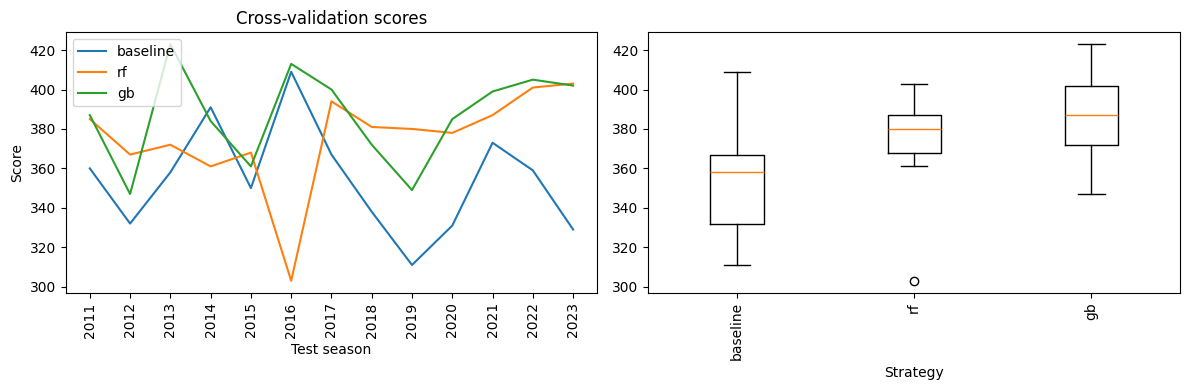

In [39]:

models = {
    "baseline": StaticEstimator([1, 0]),
    "rf": RoundingEstimator(RandomForestRegressor(
        criterion=rf_study.best_params['criterion'], 
        max_depth=rf_study.best_params['max_depth'], 
        n_estimators=rf_study.best_params['n_estimators'], 
        min_samples_split=rf_study.best_params['min_samples_split']
    )),
    "gb": build_gb_model(gb_study)
}

all_scores = []

for model in models.values():
    print(f"Scoring {model}")
    scores = cross_val_score(model, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    all_scores.append(scores)

all_scores = np.array(all_scores)
labels = models.keys()

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
split_test_seasons = [df_matches.iloc[split[1][0]]["leagueSeason"] for  split in splits]
axs[0].plot(all_scores.T, label=labels)
axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
axs[0].set_xlabel("Test season")
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].set_title("Cross-validation scores")

axs[1].boxplot(all_scores.T)
axs[1].set_xlabel("Strategy")
axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=90, ha="center")
fig.tight_layout()
!
